# Feature Selection Notebook

This notebook handles feature selection for a fraud detection project, using a combination of statistical filtering and model-based selection.

It starts by computing the Kolmogorov-Smirnov (KS) statistic for each candidate variable to see how well it separates good and bad transactions individually. The strongest variables based on this measure are kept for the next stage.

After filtering, it runs a wrapper method using a LightGBM model and sequential forward selection. Variables are added one at a time based on how much they improve detection performance, measured by false discovery rate (FDR) across cross-validation folds.

By the end, the notebook produces a focused set of features that perform well both on their own and when used together, providing a strong foundation for training the final fraud models.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline

In [112]:
# set some parameters
num_files = 1
# Set num_filter to be about 10 to 20% of the original # variables
num_filter = 400
# Set num_wrapper to be about 50, look for a saturation of the model performance as variables are added
# Can run again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [113]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables_smaller.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file. use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables_smaller.csv size is (97496, 1330)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
candidate_variables_smaller.csv                       variable  filter score
1                        Fraud      1.000000
28             Cardnum_total_3      0.621932
19             Cardnum_total_1      0.619658
10             Cardnum_total_0      0.591318
15             Cardnum_count_1      0.567429
37             Cardnum_total_7      0.564245
24             Cardnum_count_3      0.563356
586           Card_dow_total_7      0.542303
17               Cardnum_max_1      0.532080
33             Cardnum_count_7      0.526897
8                Cardnum_max_0      0.525418
6              Cardnum_count_0      0.516123
595          Card_dow_total_14      0.511203
26               Cardnum_max_3      0.501170
46            Cardnum_total_14      0.494375
584             Card_dow_max_7      0.486177
860      Cardnum_vdratio_1by14      0.485431
904  Cardnum_variability_m

In [114]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [115]:
filter_score.head(30)

variable  filter score
0                                   Fraud      1.000000
1                         Cardnum_total_3      0.621932
2                         Cardnum_total_1      0.619658
3                         Cardnum_total_0      0.591318
4                         Cardnum_count_1      0.567429
5                         Cardnum_total_7      0.564245
6                         Cardnum_count_3      0.563356
7                        Card_dow_total_7      0.542303
8                           Cardnum_max_1      0.532080
9                         Cardnum_count_7      0.526897
10                          Cardnum_max_0      0.525418
11                        Cardnum_count_0      0.516123
12                      Card_dow_total_14      0.511203
13                          Cardnum_max_3      0.501170
14                       Cardnum_total_14      0.494375
15                         Card_dow_max_7      0.486177
16                  Cardnum_vdratio_1by14      0.485431
17              Cardnum_variability_max_0      0.484245
18                       Card_dow_count_7      0.482384
19                  Cardnum_actual/toal_0      0.479550
20                 Card_dow_vdratio_0by14      0.479086
21              Cardnum_variability_max_1      0.477836
22  Cardnum_unique_count_for_card_state_1      0.476067
23    Cardnum_unique_count_for_card_zip_1      0.474960
24                      Card_dow_total_30      0.474759
25    Cardnum_unique_count_for_Merchnum_1      0.472017
26                        Card_dow_max_14      0.470975
27                  Card_dow_vdratio_0by7      0.467961
28                   Cardnum_vdratio_1by7      0.466766
29  Cardnum_unique_count_for_card_state_3      0.466410

In [116]:
filter_score.tail(10)

variable  filter score
1320    card_merch_unique_count_for_card_state_30      0.000163
1321    merch_zip_unique_count_for_merch_state_60      0.000138
1322  Card_Merchdesc_unique_count_for_state_des_1      0.000125
1323    card_merch_unique_count_for_card_state_14      0.000100
1324    merch_zip_unique_count_for_merch_state_30      0.000100
1325     card_merch_unique_count_for_card_state_7      0.000088
1326     card_merch_unique_count_for_card_state_3      0.000063
1327    merch_zip_unique_count_for_merch_state_14      0.000025
1328     merch_zip_unique_count_for_merch_state_7      0.000013
1329        card_merch_unique_count_for_Cardnum_1      0.000000

In [117]:
filter_score.shape

(1330, 2)

In [118]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_count_for_Card_Merchdesc_1', 'Card_dow_unique_count_for_state_des_1', 'Card_dow_unique_count_for_merch_zip_1', 'Cardnum_unique_count_for_

In [119]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

Cardnum_total_3  Cardnum_total_1  Cardnum_total_0  Cardnum_count_1  \
Recnum                                                                       
3466            1964.73          1551.02           333.47                3   
3467             834.91           660.87             4.37                2   
3468            8459.94          2904.08           271.93                7   
3469             838.53           664.49             7.99                3   
3470              16.28            16.28            16.28                1   

        Cardnum_total_7  Cardnum_count_3  Card_dow_total_7  Cardnum_max_1  \
Recnum                                                                      
3466            3591.53                7            333.47         930.41   
3467             997.73               34            109.97         656.50   
3468            9674.14               14            271.93        1380.45   
3469            1001.35               35            113.59         656.50   
3470              16.28                1             16.28          16.28   

        Cardnum_count_7  Cardnum_max_0  ...  Card_dow_variability_avg_7  \
Recnum                                  ...                               
3466                  9         333.47  ...                    0.000000   
3467                 72           4.37  ...                    0.028800   
3468                 17         271.93  ...                    0.000000   
3469                 73           4.37  ...                    0.748846   
3470                  1          16.28  ...                    0.000000   

        Merchnum_actual/med_60  Merchdesc_dow_max_60  merch_zip_actual/med_60  \
Recnum                                                                          
3466                  1.331802                604.00                 1.331802   
3467                  1.168449                  4.37                 1.168449   
3468                  1.000000                271.93                 1.000000   
3469                  0.977058                  4.37                 0.977058   
3470                  0.108548                 16.28                 0.108548   

        Merchnum_desc_med_3  state_des_med_3  Cardnum_med_1  \
Recnum                                                        
3466                105.920          105.920        333.470   
3467                  4.370            8.685        330.435   
3468                271.930          271.930        271.930   
3469                  3.995            4.370          4.370   
3470                 65.075           65.075         16.280   

        card_state_actual/max_1  Merchdesc_dow_total_60  Merchdesc_dow_avg_60  
Recnum                                                                         
3466                   1.000000                 2077.94              259.7425  
3467                   1.000000                    4.37                4.3700  
3468                   0.975604                  271.93              271.9300  
3469                   0.828375                    7.99                3.9950  
3470                   1.000000                   16.28               16.2800  

[5 rows x 400 columns]

In [120]:
df_keep.shape

(81476, 400)

In [121]:
Y.head()

Fraud
Recnum       
3466        0
3467        0
3468        0
3469        0
3470        0

In [122]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [123]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [125]:
print(X.shape,Y.shape)

(81476, 400) (81476,)


In [126]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [128]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [129]:
njobs = -1

In [130]:
%%time
import warnings 
warnings.filterwarnings("ignore") 


nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-njobs) # use for backward selection
sfs.fit(X,Y)

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Nu

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Nu

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromS

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Nu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Au

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 3
[LightGBM] [Info] [binary:BoostFromS

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number 

[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 4
[LightGBM] [Info] [binary:BoostFromS

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 4073

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Inf

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Au

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] St

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [In

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [I

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGB

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003171 seconds.
You can set `force_col_wise=true` to remove th

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGB

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [I

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] 

[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set 

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 4073

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFro

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Numbe

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] 

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2116
[LightGBM] [Info] Number of data points in th

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2116
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2107
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[Light

You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2555
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading

You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading

And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 11
[LightGBM] [Info] [binary:Bo

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[Light

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info

[LightGBM] [Info] Total Bins 2465
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_col_wise=true` to remove 

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in th

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Total Bins 2812
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can se

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3162
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in th

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[Light

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007368 seconds.
You can set `force_col_wise=true` to remove 

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3091
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3131
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3135
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] 

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3156
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [bin

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3346
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostF

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3346
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [bin

[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can se

[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [bin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] 

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [bin

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 407

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Num

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] 

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 407

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3325
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3431
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 18
[LightGBM] [Info] [bin

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 407

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3619
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] 

[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 407

CPU times: user 10.5 s, sys: 5.87 s, total: 16.3 s
Wall time: 4min 4s


SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x17a2a1280>)

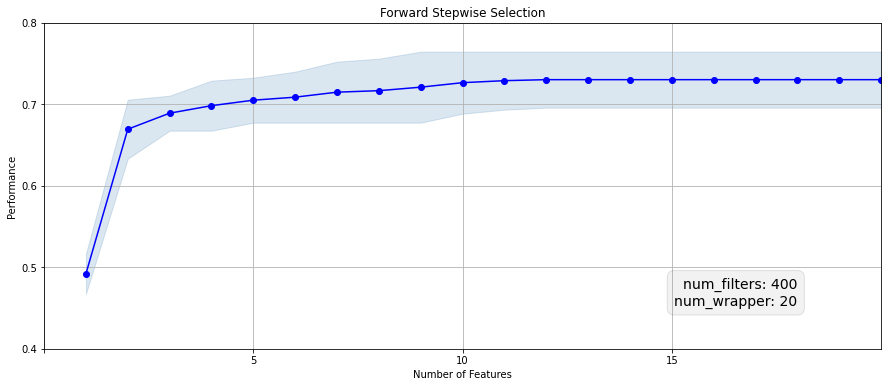

In [133]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(15, 6))

plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0, 1, step=0.1))

plt.ylim([0.4, 0.8])
plt.xlim(0, num_wrapper)

plt.title('Forward Stepwise Selection')
plt.grid()

# Adding text for num_filters and num_wrapper on the bottom right of the graph.
# Adjust the x and y coordinates as needed to fit within your plot range.
plt.text(num_wrapper * 0.9, 0.45, f'num_filters: {num_filter}\nnum_wrapper: {num_wrapper}', 
         fontsize=14, ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', facecolor='gray', alpha=0.1))

# plt.savefig('performance_nvars.png')
plt.show()

In [134]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [135]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]


In [136]:
ordered_vars_FS

feature_idx  \
1                                               (21,)   
2                                           (21, 107)   
3                                      (21, 107, 271)   
4                                 (21, 107, 120, 271)   
5                             (21, 33, 107, 120, 271)   
6                        (21, 33, 107, 120, 124, 271)   
7                   (21, 33, 107, 120, 124, 125, 271)   
8               (19, 21, 33, 107, 120, 124, 125, 271)   
9          (19, 21, 33, 107, 118, 120, 124, 125, 271)   
10    (19, 21, 33, 107, 118, 120, 121, 124, 125, 271)   
11  (19, 21, 33, 98, 107, 118, 120, 121, 124, 125,...   
12  (19, 21, 33, 98, 107, 118, 120, 121, 124, 125,...   
13  (13, 19, 21, 33, 98, 107, 118, 120, 121, 124, ...   
14  (13, 19, 21, 26, 33, 98, 107, 118, 120, 121, 1...   
15  (13, 19, 21, 26, 33, 34, 98, 107, 118, 120, 12...   
16  (13, 19, 21, 26, 33, 34, 36, 98, 107, 118, 120...   
17  (13, 19, 21, 26, 33, 34, 36, 40, 98, 107, 118,...   
18  (13, 19, 21, 26, 33, 34, 36, 40, 41, 98, 107, ...   
19  (13, 19, 21, 26, 33, 34, 36, 40, 41, 43, 98, 1...   
20  (13, 19, 21, 26, 33, 34, 36, 40, 41, 43, 44, 9...   

                                    cv_scores avg_score  \
1   [0.5165644171779141, 0.46748466257668714]  0.492025   
2    [0.7055214723926381, 0.6331288343558282]  0.669325   
3    [0.7104294478527607, 0.6674846625766871]  0.688957   
4    [0.7288343558282209, 0.6674846625766871]   0.69816   
5    [0.7325153374233129, 0.6773006134969325]  0.704908   
6    [0.7398773006134969, 0.6773006134969325]  0.708589   
7    [0.7521472392638037, 0.6773006134969325]  0.714724   
8    [0.7558282208588957, 0.6773006134969325]  0.716564   
9    [0.7644171779141105, 0.6773006134969325]  0.720859   
10   [0.7644171779141105, 0.6883435582822086]   0.72638   
11   [0.7644171779141105, 0.6932515337423313]  0.728834   
12   [0.7644171779141105, 0.6957055214723926]  0.730061   
13   [0.7644171779141105, 0.6957055214723926]  0.730061   
14   [0.7644171779141105, 0.6957055214723926]  0.730061   
15   [0.7644171779141105, 0.6957055214723926]  0.730061   
16   [0.7644171779141105, 0.6957055214723926]  0.730061   
17   [0.7644171779141105, 0.6957055214723926]  0.730061   
18   [0.7644171779141105, 0.6957055214723926]  0.730061   
19   [0.7644171779141105, 0.6957055214723926]  0.730061   
20   [0.7644171779141105, 0.6957055214723926]  0.730061   

                                        feature_names  ci_bound   std_dev  \
1            (Cardnum_unique_count_for_card_state_1,)  0.105587   0.02454   
2   (Cardnum_unique_count_for_card_state_1, Card_M...   0.15574  0.036196   
3   (Cardnum_unique_count_for_card_state_1, Card_M...  0.092388  0.021472   
4   (Cardnum_unique_count_for_card_state_1, Card_M...  0.131983  0.030675   
5   (Cardnum_unique_count_for_card_state_1, Card_d...  0.118785  0.027607   
6   (Cardnum_unique_count_for_card_state_1, Card_d...  0.134623  0.031288   
7   (Cardnum_unique_count_for_card_state_1, Card_d...   0.16102  0.037423   
8   (Card_dow_vdratio_0by14, Cardnum_unique_count_...  0.168939  0.039264   
9   (Card_dow_vdratio_0by14, Cardnum_unique_count_...  0.187416  0.043558   
10  (Card_dow_vdratio_0by14, Cardnum_unique_count_...  0.163659  0.038037   
11  (Card_dow_vdratio_0by14, Cardnum_unique_count_...  0.153101  0.035583   
12  (Card_dow_vdratio_0by14, Cardnum_unique_count_...  0.147821  0.034356   
13  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
14  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
15  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
16  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
17  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
18  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
19  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821  0.034356   
20  (Cardnum_total_14, Card_dow_vdratio_0by14, Car...  0.147821 

In [137]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [138]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1          Cardnum_unique_count_for_card_state_1
2                         Card_Merchdesc_total_7
3                       card_merch_vdratio_0by14
4                       Cardnum_count_0_by_60_sq
5     Card_dow_unique_count_for_Card_Merchdesc_1
6                              state_des_total_3
7                      card_zip_count_1_by_60_sq
8                         Card_dow_vdratio_0by14
9                                 Cardnum_max_14
10                       Card_Merchdesc_total_30
11                           card_state_total_14
12                          Card_Merchdesc_avg_7
13                              Cardnum_total_14
14                         Card_dow_vdratio_0by7
15         Card_dow_unique_count_for_state_des_1
16         Cardnum_unique_count_for_card_state_7
17           Cardnum_unique_count_for_card_zip_7
18           Cardnum_unique_count_for_Merchnum_7
19                             Cardnum_day_since
20                            Card_dow_day_since
Name: variable name,

In [139]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

filter score
variable                                               
Cardnum_total_3                                0.621932
Cardnum_total_1                                0.619658
Cardnum_total_0                                0.591318
Cardnum_count_1                                0.567429
Cardnum_total_7                                0.564245
...                                                 ...
card_merch_unique_count_for_card_state_7       0.000088
card_merch_unique_count_for_card_state_3       0.000063
merch_zip_unique_count_for_merch_state_14      0.000025
merch_zip_unique_count_for_merch_state_7       0.000013
card_merch_unique_count_for_Cardnum_1          0.000000

[1329 rows x 1 columns]

In [140]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

Empty DataFrame
Columns: []
Index: [Cardnum_unique_count_for_card_state_1, Card_Merchdesc_total_7, card_merch_vdratio_0by14, Cardnum_count_0_by_60_sq, Card_dow_unique_count_for_Card_Merchdesc_1]

In [141]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [142]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

wrapper order                                    variable  filter score
0               1       Cardnum_unique_count_for_card_state_1      0.476067
1               2                      Card_Merchdesc_total_7      0.324631
2               3                    card_merch_vdratio_0by14      0.266699
3               4                    Cardnum_count_0_by_60_sq      0.317871
4               5  Card_dow_unique_count_for_Card_Merchdesc_1      0.447250
5               6                           state_des_total_3      0.315540
6               7                   card_zip_count_1_by_60_sq      0.314822
7               8                      Card_dow_vdratio_0by14      0.479086
8               9                              Cardnum_max_14      0.318826
9              10                     Card_Merchdesc_total_30      0.317152
10             11                         card_state_total_14      0.332008
11             12                        Card_Merchdesc_avg_7      0.278124
12             13                            Cardnum_total_14      0.494375
13             14                       Card_dow_vdratio_0by7      0.467961
14             15       Card_dow_unique_count_for_state_des_1      0.447238
15             16       Cardnum_unique_count_for_card_state_7      0.445967
16             17         Cardnum_unique_count_for_card_zip_7      0.438242
17             18         Cardnum_unique_count_for_Merchnum_7      0.436938
18             19                           Cardnum_day_since      0.432169
19             20                          Card_dow_day_since      0.432169

In [143]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_total_7',
 'card_merch_vdratio_0by14',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_Card_Merchdesc_1',
 'state_des_total_3',
 'card_zip_count_1_by_60_sq',
 'Card_dow_vdratio_0by14',
 'Cardnum_max_14',
 'Card_Merchdesc_total_30',
 'card_state_total_14',
 'Card_Merchdesc_avg_7',
 'Cardnum_total_14',
 'Card_dow_vdratio_0by7',
 'Card_dow_unique_count_for_state_des_1',
 'Cardnum_unique_count_for_card_state_7',
 'Cardnum_unique_count_for_card_zip_7',
 'Cardnum_unique_count_for_Merchnum_7',
 'Cardnum_day_since',
 'Card_dow_day_since',
 'Recnum',
 'Fraud']

In [144]:
filter_score

filter score
variable                                               
Cardnum_total_3                                0.621932
Cardnum_total_1                                0.619658
Cardnum_total_0                                0.591318
Cardnum_count_1                                0.567429
Cardnum_total_7                                0.564245
...                                                 ...
card_merch_unique_count_for_card_state_7       0.000088
card_merch_unique_count_for_card_state_3       0.000063
merch_zip_unique_count_for_merch_state_14      0.000025
merch_zip_unique_count_for_merch_state_7       0.000013
card_merch_unique_count_for_Cardnum_1          0.000000

[1329 rows x 1 columns]

In [145]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 7.29 s, sys: 1.17 s, total: 8.47 s
Wall time: 8.67 s


(97496, 1330)

In [146]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 22)


In [147]:
df_keep.to_csv('vars_final.csv',index=False)